# Midterm 3
## Assignment 2, Image segmentation on horse dataset
## Luca Palumbo, 639750

### Setup and utility function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tqdm import tqdm
from PIL import Image

import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

Download and extract the Weizmann Horse Database from Kaggle. Create the dataset directory if it does not exist.

In [ ]:
dataset_path = "./dataset"
if not os.path.exists(dataset_path):
  !mkdir dataset
  !curl -L -o ./dataset/archive.zip  https://www.kaggle.com/api/v1/datasets/download/ztaihong/weizmann-horse-database
  !unzip -q ./dataset/archive -d ./dataset
  !rm ./dataset/archive.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  113M  100  113M    0     0  13.4M      0  0:00:08  0:00:08 --:--:-- 21.0M


Since the original dataset contains images of varying dimensions, all images and masks are resized to a fixed resolution of $256 \times 256$ pixels.

The dataset is then split into three subsets with the following proportions:

- Training: $60\%$

- Validation: $20\%$

- Test: $20\%$

The `resize_and_split` function handles both the resizing and the splitting process. Images are resized using bilinear interpolation, and the same is applied to the masks.

After processing, a random sample from the training set is visualized along with its corresponding mask.



In [ ]:

resized_path = './dataset/resized'
dataset_path = './dataset/weizmann_horse_db'


def resize_and_split(target_size=(256, 256), split_ratio=(0.6, 0.2, 0.2)):
    assert sum(split_ratio) == 1.0, "Sum of split ratios must be 1."

    input_dirs = {
        "image": os.path.join(dataset_path, "horse"),
        "mask": os.path.join(dataset_path, "mask")
    }

    subsets = ["train", "test", "validation"]
    output_dirs = {
        subset: {
            "image": os.path.join(resized_path, subset, "horse"),
            "mask": os.path.join(resized_path, subset, "mask")
        } for subset in subsets
    }

    # Crea tutte le cartelle necessarie
    for dirs in output_dirs.values():
        os.makedirs(dirs["image"], exist_ok=True)
        os.makedirs(dirs["mask"], exist_ok=True)

    image_filenames = [f for f in os.listdir(input_dirs["image"]) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    np.random.shuffle(image_filenames)

    # Calcola le soglie per gli split
    n_total = len(image_filenames)
    n_train = int(split_ratio[0] * n_total)
    n_test = int(split_ratio[1] * n_total)

    for i, filename in enumerate(tqdm(image_filenames, desc="Resizing and splitting")):
        subset = "train" if i < n_train else "test" if i < n_train + n_test else "validation"

        img_path = os.path.join(input_dirs["image"], filename)
        mask_path = os.path.join(input_dirs["mask"], filename)

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        img_resized = img.resize(target_size, Image.BILINEAR)
        mask_resized = mask.resize(target_size, Image.BILINEAR)

        img_resized.save(os.path.join(output_dirs[subset]["image"], filename))
        mask_resized.save(os.path.join(output_dirs[subset]["mask"], filename))


resize_and_split()

Resizing and splitting: 100%|██████████| 327/327 [00:12<00:00, 26.81it/s]


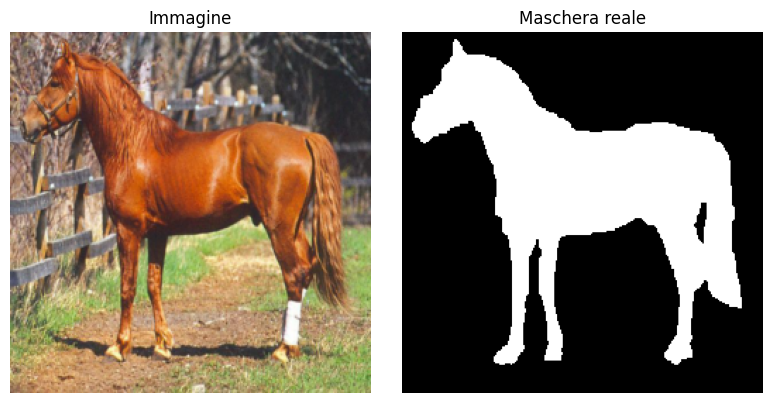

In [ ]:
def plot_tensor_image(tensor):
    """
    Plotta un'immagine a partire da un tensore con shape (1, N, 512, 512).
    N può essere 1 (maschera binaria) oppure 3 (RGB).
    """
    # Rimuovi la dimensione della batch
    if tensor.dim() == 4:
      tensor = tensor.squeeze(0)  # Risulta (N, 512, 512)

    if tensor.shape[0] == 1:
        # Maschera binaria: shape (1, 512, 512) -> (512, 512)
        image = tensor.squeeze(0).cpu().numpy()
        plt.imshow(image, cmap='gray', vmin=0, vmax=1)
    elif tensor.shape[0] == 3:
        # Immagine RGB: shape (3, 512, 512) -> (512, 512, 3)
        image = tensor.permute(1, 2, 0).cpu().numpy()
        plt.imshow(image)
    else:
        raise ValueError(f"Numero di canali non supportato: {tensor.shape[0]}")

    plt.axis('off')
    plt.show()

def plot_image_and_masks(image_tensor, pred_mask_tensor=None, true_mask_tensor=None):
    """
    Mostra affiancate:
    - immagine RGB (shape: [1, 3, H, W])
    - maschera predetta (shape: [1, 1, H, W])
    - maschera vera (shape: [1, 1, H, W])
    """
    axes_idx = 0
    num_images = 1 + (pred_mask_tensor is not None) + (true_mask_tensor is not None)
    fig, axes = plt.subplots(1, num_images , figsize=(4*num_images, 4))


    image = image_tensor.squeeze(0)             # [3, H, W]
    # Immagine RGB
    img_rgb = image.permute(1, 2, 0).cpu().numpy()  # [H, W, 3]
    axes[axes_idx].imshow(img_rgb)
    axes[axes_idx].set_title("Immagine")
    axes[axes_idx].axis('off')
    axes_idx += 1

    if pred_mask_tensor!=None:
      pred_mask = pred_mask_tensor.squeeze(0)     # [1, H, W]
      # Maschera predetta
      pred = pred_mask.squeeze(0).cpu().detach().numpy()  # [H, W]
      axes[axes_idx].imshow(pred, cmap='gray', vmin=0, vmax=1)
      axes[axes_idx].set_title("Maschera predetta")
      axes[axes_idx].axis('off')
      axes_idx += 1

    if true_mask_tensor!=None:
      true_mask = true_mask_tensor.squeeze(0)     # [1, H, W]
      # Maschera vera
      true = true_mask.squeeze(0).cpu().numpy()  # [H, W]
      axes[axes_idx].imshow(true, cmap='gray', vmin=0, vmax=1)
      axes[axes_idx].set_title("Maschera reale")
      axes[axes_idx].axis('off')

    plt.tight_layout()
    plt.show()

# take one image randomly from resized/train/horse and plot it alongsize it's mask
name = np.random.choice(os.listdir(os.path.join(resized_path, 'train', 'horse')))
img = Image.open(os.path.join(resized_path, 'train', 'horse', name))
mask = Image.open(os.path.join(resized_path, 'train', 'mask', name))
plot_image_and_masks(
    image_tensor = transforms.ToTensor()(img).unsqueeze(0),
    true_mask_tensor=(transforms.ToTensor()(mask) > 0).float().unsqueeze(0),
)

### The U-NET

U-Net is well-suited for image segmentation tasks due to its symmetric encoder-decoder structure with skip connections, which allows precise localization by combining spatial and contextual information.

The implemented architecture is composed of:

- 4 encoder blocks

   Each block includes:
   - Two convolutional layers (kernel size 3, padding 1) with ReLU activation, preserving spatial dimensions.

  - One max pooling layer (kernel size 2), reducing dimensions by half.

- 4 decoder blocks

  Each block includes:

  - Two convolutional layers (kernel size 3, padding 1) with ReLU activation.

  - One transposed convolutional layer (kernel size 2, stride 2), doubling the spatial dimensions.

- 1 final block

Includes:

  - Two convolutional layers (kernel size 3, padding 1) with ReLU activation.

  - One output convolutional layer (kernel size 1) producing a single-channel output.

The model outputs a tensor of shape $Batch \times 1 \times H \times W$, with unbounded real values. This is compatible with the `BCEWithLogitsLoss`, which combines a sigmoid activation with binary cross-entropy for numerical stability.

In [ ]:

class EncoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1, pooling_size=2):
        super(EncoderBlock, self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.kernel_size = kernel_size
        self.padding = padding
        self.pooling_size = pooling_size

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(self.in_channel, self.out_channel, self.kernel_size, padding=self.padding),
            nn.ReLU()
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(self.out_channel, self.out_channel, self.kernel_size, padding=self.padding),
            nn.ReLU()
        )
        self.pooling = nn.MaxPool2d(pooling_size)

    def forward(self, x):
        x = self.conv_layer_1(x)
        conn = self.conv_layer_2(x)
        x = self.pooling(conn)
        return x, conn


class DecoderBlock(nn.Module):
    def __init__(self,in_channel, mid_channels, out_channels, kernel_size_conv=3, kernel_size_up_conv=2, padding=1, stride=2):
        super(DecoderBlock, self).__init__()
        self.in_channels = in_channel
        self.mid_channels = mid_channels
        self.out_channels = out_channels
        self.kernel_size_conv = kernel_size_conv
        self.kernel_size_up_conv = kernel_size_up_conv
        self.padding = padding
        self.stride = stride

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(self.in_channels, self.mid_channels, kernel_size_conv, padding=self.padding),
            nn.ReLU(),
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(self.mid_channels, self.mid_channels, kernel_size_conv, padding=self.padding),
            nn.ReLU(),
        )

        self.up_conv = nn.ConvTranspose2d(self.mid_channels, self.out_channels, self.kernel_size_up_conv, self.stride)

    def forward(self,x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.up_conv(x)
        return x


class FinalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=1):
        super(FinalBlock,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, padding=self.padding),
            nn.ReLU()
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(self.out_channels, self.out_channels, self.kernel_size, padding=self.padding),
            nn.ReLU()
        )

        self.conv_layer_3 = nn.Conv2d(self.out_channels, 1, 1)


    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        return x


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder_block_1 = EncoderBlock( 3, 64 )
        self.encoder_block_2 = EncoderBlock( 64, 128 )
        self.encoder_block_3 = EncoderBlock( 128, 256 )
        self.encoder_block_4 = EncoderBlock( 256, 512 )

        self.decoder_block_1 = DecoderBlock( 512, 1024, 512 )
        self.decoder_block_2 = DecoderBlock( 1024, 512, 256 )
        self.decoder_block_3 = DecoderBlock( 512, 256, 128 )
        self.decoder_block_4 = DecoderBlock( 256, 128, 64 )

        self.final_block = FinalBlock(128, 64, 3)

    def forward(self, x):
        x, conn1 = self.encoder_block_1(x)
        x, conn2 = self.encoder_block_2(x)
        x, conn3 = self.encoder_block_3(x)
        x, conn4 = self.encoder_block_4(x)

        x = self.decoder_block_1(x)
        x = self.decoder_block_2( torch.cat((conn4, x), dim=1) )
        x = self.decoder_block_3( torch.cat((conn3, x), dim=1) )
        x = self.decoder_block_4( torch.cat((conn2, x), dim=1) )

        x = self.final_block( torch.cat((conn1, x), dim=1) )

        return x


### Dataset class with augmentation

The following class defines a custom Dataset for easy and consistent access to image-mask pairs during training and evaluation.

To improve model generalization, data augmentation is applied only during training. For each image, the following augmentations are applied with 50% probability:

- Horizontal flip

- Vertical flip

- Rotation by a random angle $\theta \in [-90^\circ, 90^\circ]$

Masks are augmented with the same transformations to preserve alignment with their corresponding images.

After defining the class, we instantiate three datasets: training (with augmentation), validation, and test (both without augmentation). Finally, we visualize a sample from the training dataset to observe the effect of augmentation.

In [ ]:
class HorseDataset(Dataset):
    def __init__(self, image_dir, mask_dir, augment=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.augment = augment
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.augment:
            if np.random.rand() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            if np.random.rand() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            if np.random.rand() > 0.5:
                angle = np.random.uniform(-90,90)
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)


        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        mask = (mask > 0).float()

        return image, mask

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


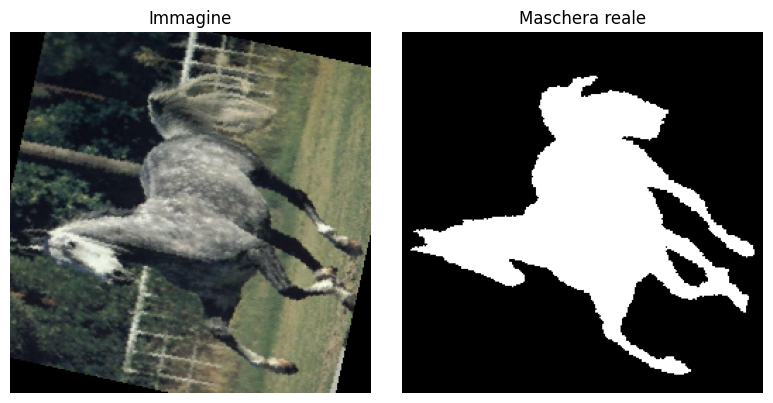

In [ ]:
data_dir = os.path.join('dataset', 'resized', 'train', 'horse')
mask_dir = os.path.join('dataset', 'resized', 'train', 'mask')
train_dataset = HorseDataset(data_dir, mask_dir, augment=True)

data_dir = os.path.join('dataset', 'resized', 'test', 'horse')
mask_dir = os.path.join('dataset', 'resized', 'test', 'mask')
test_dataset = HorseDataset(data_dir, mask_dir)

data_dir = os.path.join('dataset', 'resized', 'validation', 'horse')
mask_dir = os.path.join('dataset', 'resized', 'validation', 'mask')
validation_dataset = HorseDataset(data_dir, mask_dir)

img, mask = train_dataset[0]
print(img.shape)
print(mask.shape)
plot_image_and_masks(img, true_mask_tensor=mask)

### Training with early stopping

This section introduces early stopping to avoid overfitting and save the best model.
The EarlyStopping class monitors the validation loss, and training stops if no improvement is observed for 5 consecutive epochs (patience). The best model is saved to checkpoint.pt.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model, path='checkpoint.pt'):
        score = -val_loss  # Più alto è meglio (perché la loss deve diminuire)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        '''Salva il modello se la validation loss diminuisce.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

For training:

- Optimizer: Adam with learning rate $10^{-4}$

- Batch size: 5

- Loss function: Binary Cross Entropy with logits

- Device: GPU if available, otherwise CPU

- The training loop continues until early stopping is triggered.

To ensure reproducibility, both NumPy and PyTorch seeds are fixed.
If a previous checkpoint exists, it's loaded before starting.

In [ ]:

np.random.seed(0xdeadbeef)
torch.manual_seed(0xdeadbeef)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

unet = UNet()
# if checkpoint.pt is present load it
if os.path.exists('checkpoint.pt'):
    print('Loading checkpoint...')
    unet = UNet()
    unet.load_state_dict(torch.load('checkpoint.pt'))
unet = unet.to(device)
optimizer = optim.Adam( unet.parameters(), lr = 1e-4)
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=5, shuffle=True)
loss_function = nn.BCEWithLogitsLoss()

early_stopping = EarlyStopping(patience=5, verbose=True)

epoch = 0
while (True):
    unet.train()
    progress_bar = tqdm(train_dataloader)
    for batch, batch_mask  in progress_bar:
        optimizer.zero_grad()
        batch      = batch.to(device)
        batch_mask = batch_mask.to(device)
        batch_mask_predicted = unet(batch)
        train_loss = loss_function(batch_mask_predicted, batch_mask)
        progress_bar.set_description(f'Epoch {epoch+1} - Train Loss: \t{train_loss.item():.4f}')
        train_loss.backward()
        optimizer.step()

    unet.eval()
    with torch.no_grad():
      validation_loss = 0
      progress_bar = tqdm(train_dataloader)
      for batch, batch_mask in progress_bar:
          batch      = batch.to(device)
          batch_mask = batch_mask.to(device)
          batch_mask_predicted = unet(batch)
          validation_loss += loss_function(batch_mask_predicted, batch_mask)
          progress_bar.set_description(f'Epoch {epoch+1} - Validation Loss: \t{validation_loss.item():.4f}')

    early_stopping(validation_loss, unet)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    epoch+=1

Using device: cuda


Epoch 1 - Validation Loss: 	22.3817: 100%|██████████| 40/40 [00:04<00:00,  8.75it/s]


Validation loss decreased (inf --> 22.381708). Saving model...


Epoch 2 - Validation Loss: 	21.3606: 100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


Validation loss decreased (22.381708 --> 21.360577). Saving model...


Epoch 3 - Validation Loss: 	19.9466: 100%|██████████| 40/40 [00:04<00:00,  9.00it/s]


Validation loss decreased (21.360577 --> 19.946566). Saving model...


Epoch 4 - Validation Loss: 	18.4035: 100%|██████████| 40/40 [00:04<00:00,  8.95it/s]


Validation loss decreased (19.946566 --> 18.403484). Saving model...


Epoch 5 - Validation Loss: 	16.3926: 100%|██████████| 40/40 [00:04<00:00,  8.80it/s]


Validation loss decreased (18.403484 --> 16.392553). Saving model...


Epoch 6 - Validation Loss: 	15.4305: 100%|██████████| 40/40 [00:04<00:00,  8.34it/s]


Validation loss decreased (16.392553 --> 15.430480). Saving model...


Epoch 7 - Validation Loss: 	14.1318: 100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


Validation loss decreased (15.430480 --> 14.131813). Saving model...


Epoch 8 - Validation Loss: 	13.5646: 100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Validation loss decreased (14.131813 --> 13.564590). Saving model...


Epoch 9 - Validation Loss: 	12.6779: 100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Validation loss decreased (13.564590 --> 12.677945). Saving model...


Epoch 10 - Validation Loss: 	13.8770: 100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


EarlyStopping counter: 1 out of 5


Epoch 11 - Validation Loss: 	12.3970: 100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Validation loss decreased (12.677945 --> 12.396970). Saving model...


Epoch 12 - Validation Loss: 	12.8017: 100%|██████████| 40/40 [00:04<00:00,  8.70it/s]


EarlyStopping counter: 1 out of 5


Epoch 13 - Validation Loss: 	11.7323: 100%|██████████| 40/40 [00:04<00:00,  8.30it/s]


Validation loss decreased (12.396970 --> 11.732267). Saving model...


Epoch 14 - Validation Loss: 	11.3979: 100%|██████████| 40/40 [00:04<00:00,  8.48it/s]


Validation loss decreased (11.732267 --> 11.397883). Saving model...


Epoch 15 - Validation Loss: 	11.8784: 100%|██████████| 40/40 [00:04<00:00,  8.71it/s]


EarlyStopping counter: 1 out of 5


Epoch 16 - Validation Loss: 	12.2892: 100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


EarlyStopping counter: 2 out of 5


Epoch 17 - Validation Loss: 	12.3956: 100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


EarlyStopping counter: 3 out of 5


Epoch 18 - Validation Loss: 	11.1686: 100%|██████████| 40/40 [00:04<00:00,  8.43it/s]


Validation loss decreased (11.397883 --> 11.168558). Saving model...


Epoch 19 - Validation Loss: 	11.0538: 100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


Validation loss decreased (11.168558 --> 11.053797). Saving model...


Epoch 20 - Validation Loss: 	11.0589: 100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


EarlyStopping counter: 1 out of 5


Epoch 21 - Validation Loss: 	11.1381: 100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


EarlyStopping counter: 2 out of 5


Epoch 22 - Validation Loss: 	10.6103: 100%|██████████| 40/40 [00:04<00:00,  8.55it/s]


Validation loss decreased (11.053797 --> 10.610287). Saving model...


Epoch 23 - Validation Loss: 	10.3442: 100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Validation loss decreased (10.610287 --> 10.344208). Saving model...


Epoch 24 - Validation Loss: 	11.1260: 100%|██████████| 40/40 [00:04<00:00,  8.74it/s]


EarlyStopping counter: 1 out of 5


Epoch 25 - Validation Loss: 	10.3885: 100%|██████████| 40/40 [00:04<00:00,  8.29it/s]


EarlyStopping counter: 2 out of 5


Epoch 26 - Validation Loss: 	11.4080: 100%|██████████| 40/40 [00:04<00:00,  8.57it/s]


EarlyStopping counter: 3 out of 5


Epoch 27 - Validation Loss: 	10.2968: 100%|██████████| 40/40 [00:04<00:00,  8.76it/s]


Validation loss decreased (10.344208 --> 10.296784). Saving model...


Epoch 28 - Validation Loss: 	11.0890: 100%|██████████| 40/40 [00:04<00:00,  8.73it/s]


EarlyStopping counter: 1 out of 5


Epoch 29 - Validation Loss: 	9.9956: 100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


Validation loss decreased (10.296784 --> 9.995580). Saving model...


Epoch 30 - Validation Loss: 	11.2487: 100%|██████████| 40/40 [00:04<00:00,  8.54it/s]


EarlyStopping counter: 1 out of 5


Epoch 31 - Validation Loss: 	10.3189: 100%|██████████| 40/40 [00:04<00:00,  8.70it/s]


EarlyStopping counter: 2 out of 5


Epoch 32 - Validation Loss: 	9.7488: 100%|██████████| 40/40 [00:04<00:00,  8.77it/s]


Validation loss decreased (9.995580 --> 9.748835). Saving model...


Epoch 33 - Validation Loss: 	10.8932: 100%|██████████| 40/40 [00:04<00:00,  8.33it/s]


EarlyStopping counter: 1 out of 5


Epoch 34 - Validation Loss: 	9.6707: 100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


Validation loss decreased (9.748835 --> 9.670715). Saving model...


Epoch 35 - Validation Loss: 	10.2483: 100%|██████████| 40/40 [00:04<00:00,  8.78it/s]


EarlyStopping counter: 1 out of 5


Epoch 36 - Validation Loss: 	9.4289: 100%|██████████| 40/40 [00:04<00:00,  8.76it/s]


Validation loss decreased (9.670715 --> 9.428899). Saving model...


Epoch 37 - Validation Loss: 	10.0441: 100%|██████████| 40/40 [00:04<00:00,  8.22it/s]


EarlyStopping counter: 1 out of 5


Epoch 38 - Validation Loss: 	9.4863: 100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


EarlyStopping counter: 2 out of 5


Epoch 39 - Validation Loss: 	9.3012: 100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Validation loss decreased (9.428899 --> 9.301221). Saving model...


Epoch 40 - Validation Loss: 	9.1296: 100%|██████████| 40/40 [00:04<00:00,  8.71it/s]


Validation loss decreased (9.301221 --> 9.129583). Saving model...


Epoch 41 - Validation Loss: 	9.3742: 100%|██████████| 40/40 [00:04<00:00,  8.21it/s]


EarlyStopping counter: 1 out of 5


Epoch 42 - Validation Loss: 	9.5119: 100%|██████████| 40/40 [00:04<00:00,  8.55it/s]


EarlyStopping counter: 2 out of 5


Epoch 43 - Validation Loss: 	8.4587: 100%|██████████| 40/40 [00:04<00:00,  8.80it/s]


Validation loss decreased (9.129583 --> 8.458725). Saving model...


Epoch 44 - Validation Loss: 	9.2347: 100%|██████████| 40/40 [00:04<00:00,  8.72it/s]


EarlyStopping counter: 1 out of 5


Epoch 45 - Validation Loss: 	8.7008: 100%|██████████| 40/40 [00:04<00:00,  8.33it/s]


EarlyStopping counter: 2 out of 5


Epoch 46 - Validation Loss: 	8.3085: 100%|██████████| 40/40 [00:04<00:00,  8.47it/s]


Validation loss decreased (8.458725 --> 8.308462). Saving model...


Epoch 47 - Validation Loss: 	8.1220: 100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Validation loss decreased (8.308462 --> 8.121990). Saving model...


Epoch 48 - Validation Loss: 	8.1699: 100%|██████████| 40/40 [00:04<00:00,  8.78it/s]


EarlyStopping counter: 1 out of 5


Epoch 49 - Validation Loss: 	8.0525: 100%|██████████| 40/40 [00:04<00:00,  8.32it/s]


Validation loss decreased (8.121990 --> 8.052525). Saving model...


Epoch 50 - Validation Loss: 	8.3644: 100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


EarlyStopping counter: 1 out of 5


Epoch 51 - Validation Loss: 	8.5653: 100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


EarlyStopping counter: 2 out of 5


Epoch 52 - Validation Loss: 	7.9028: 100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


Validation loss decreased (8.052525 --> 7.902796). Saving model...


Epoch 53 - Validation Loss: 	7.6248: 100%|██████████| 40/40 [00:04<00:00,  8.32it/s]


Validation loss decreased (7.902796 --> 7.624761). Saving model...


Epoch 54 - Validation Loss: 	8.1867: 100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


EarlyStopping counter: 1 out of 5


Epoch 55 - Validation Loss: 	7.5238: 100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


Validation loss decreased (7.624761 --> 7.523788). Saving model...


Epoch 56 - Validation Loss: 	8.1208: 100%|██████████| 40/40 [00:04<00:00,  8.71it/s]


EarlyStopping counter: 1 out of 5


Epoch 57 - Validation Loss: 	7.3831: 100%|██████████| 40/40 [00:04<00:00,  8.37it/s]


Validation loss decreased (7.523788 --> 7.383145). Saving model...


Epoch 58 - Validation Loss: 	7.4879: 100%|██████████| 40/40 [00:04<00:00,  8.44it/s]


EarlyStopping counter: 1 out of 5


Epoch 59 - Validation Loss: 	7.5999: 100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


EarlyStopping counter: 2 out of 5


Epoch 60 - Validation Loss: 	7.2576: 100%|██████████| 40/40 [00:04<00:00,  8.75it/s]


Validation loss decreased (7.383145 --> 7.257568). Saving model...


Epoch 61 - Validation Loss: 	7.5165: 100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


EarlyStopping counter: 1 out of 5


Epoch 62 - Validation Loss: 	7.1853: 100%|██████████| 40/40 [00:04<00:00,  8.56it/s]


Validation loss decreased (7.257568 --> 7.185308). Saving model...


Epoch 63 - Validation Loss: 	7.2034: 100%|██████████| 40/40 [00:04<00:00,  8.74it/s]


EarlyStopping counter: 1 out of 5


Epoch 64 - Validation Loss: 	7.1599: 100%|██████████| 40/40 [00:04<00:00,  8.74it/s]


Validation loss decreased (7.185308 --> 7.159948). Saving model...


Epoch 65 - Validation Loss: 	7.0589: 100%|██████████| 40/40 [00:04<00:00,  8.24it/s]


Validation loss decreased (7.159948 --> 7.058887). Saving model...


Epoch 66 - Validation Loss: 	6.5791: 100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Validation loss decreased (7.058887 --> 6.579051). Saving model...


Epoch 67 - Validation Loss: 	7.1320: 100%|██████████| 40/40 [00:04<00:00,  8.71it/s]


EarlyStopping counter: 1 out of 5


Epoch 68 - Validation Loss: 	6.5477: 100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


Validation loss decreased (6.579051 --> 6.547716). Saving model...


Epoch 69 - Validation Loss: 	7.1050: 100%|██████████| 40/40 [00:04<00:00,  8.23it/s]


EarlyStopping counter: 1 out of 5


Epoch 70 - Validation Loss: 	6.6564: 100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


EarlyStopping counter: 2 out of 5


Epoch 71 - Validation Loss: 	6.7621: 100%|██████████| 40/40 [00:04<00:00,  8.70it/s]


EarlyStopping counter: 3 out of 5


Epoch 72 - Validation Loss: 	6.3838: 100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Validation loss decreased (6.547716 --> 6.383847). Saving model...


Epoch 73 - Validation Loss: 	6.8126: 100%|██████████| 40/40 [00:04<00:00,  8.29it/s]


EarlyStopping counter: 1 out of 5


Epoch 74 - Validation Loss: 	6.6209: 100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


EarlyStopping counter: 2 out of 5


Epoch 75 - Validation Loss: 	6.2014: 100%|██████████| 40/40 [00:04<00:00,  8.72it/s]


Validation loss decreased (6.383847 --> 6.201421). Saving model...


Epoch 76 - Validation Loss: 	6.7254: 100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


EarlyStopping counter: 1 out of 5


Epoch 77 - Validation Loss: 	6.4268: 100%|██████████| 40/40 [00:04<00:00,  8.26it/s]


EarlyStopping counter: 2 out of 5


Epoch 78 - Validation Loss: 	6.0434: 100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


Validation loss decreased (6.201421 --> 6.043420). Saving model...


Epoch 79 - Validation Loss: 	6.5006: 100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


EarlyStopping counter: 1 out of 5


Epoch 80 - Validation Loss: 	6.0321: 100%|██████████| 40/40 [00:04<00:00,  8.70it/s]


Validation loss decreased (6.043420 --> 6.032094). Saving model...


Epoch 81 - Validation Loss: 	6.3883: 100%|██████████| 40/40 [00:04<00:00,  8.19it/s]


EarlyStopping counter: 1 out of 5


Epoch 82 - Validation Loss: 	5.8134: 100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


Validation loss decreased (6.032094 --> 5.813376). Saving model...


Epoch 83 - Validation Loss: 	6.1664: 100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


EarlyStopping counter: 1 out of 5


Epoch 84 - Validation Loss: 	6.2925: 100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


EarlyStopping counter: 2 out of 5


Epoch 85 - Validation Loss: 	5.4868: 100%|██████████| 40/40 [00:04<00:00,  8.28it/s]


Validation loss decreased (5.813376 --> 5.486847). Saving model...


Epoch 86 - Validation Loss: 	6.2669: 100%|██████████| 40/40 [00:04<00:00,  8.54it/s]


EarlyStopping counter: 1 out of 5


Epoch 87 - Validation Loss: 	6.8971: 100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


EarlyStopping counter: 2 out of 5


Epoch 88 - Validation Loss: 	6.1496: 100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


EarlyStopping counter: 3 out of 5


Epoch 89 - Validation Loss: 	5.9453: 100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


EarlyStopping counter: 4 out of 5


Epoch 90 - Validation Loss: 	5.4783: 100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


Validation loss decreased (5.486847 --> 5.478271). Saving model...


Epoch 91 - Validation Loss: 	5.8173: 100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


EarlyStopping counter: 1 out of 5


Epoch 92 - Validation Loss: 	5.2887: 100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Validation loss decreased (5.478271 --> 5.288742). Saving model...


Epoch 93 - Validation Loss: 	5.6484: 100%|██████████| 40/40 [00:04<00:00,  8.33it/s]


EarlyStopping counter: 1 out of 5


Epoch 94 - Validation Loss: 	5.8026: 100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


EarlyStopping counter: 2 out of 5


Epoch 95 - Validation Loss: 	5.2790: 100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Validation loss decreased (5.288742 --> 5.279023). Saving model...


Epoch 96 - Validation Loss: 	5.8009: 100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


EarlyStopping counter: 1 out of 5


Epoch 97 - Validation Loss: 	5.3837: 100%|██████████| 40/40 [00:04<00:00,  8.32it/s]


EarlyStopping counter: 2 out of 5


Epoch 98 - Validation Loss: 	5.1375: 100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Validation loss decreased (5.279023 --> 5.137471). Saving model...


Epoch 99 - Validation Loss: 	5.6292: 100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


EarlyStopping counter: 1 out of 5


Epoch 100 - Validation Loss: 	5.4588: 100%|██████████| 40/40 [00:04<00:00,  8.57it/s]


EarlyStopping counter: 2 out of 5


Epoch 101 - Validation Loss: 	4.6797: 100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


Validation loss decreased (5.137471 --> 4.679746). Saving model...


Epoch 102 - Validation Loss: 	5.3276: 100%|██████████| 40/40 [00:04<00:00,  8.38it/s]


EarlyStopping counter: 1 out of 5


Epoch 103 - Validation Loss: 	4.7836: 100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


EarlyStopping counter: 2 out of 5


Epoch 104 - Validation Loss: 	4.9326: 100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


EarlyStopping counter: 3 out of 5


Epoch 105 - Validation Loss: 	4.9243: 100%|██████████| 40/40 [00:04<00:00,  8.30it/s]


EarlyStopping counter: 4 out of 5


Epoch 106 - Validation Loss: 	4.5119: 100%|██████████| 40/40 [00:04<00:00,  8.44it/s]


Validation loss decreased (4.679746 --> 4.511867). Saving model...


Epoch 107 - Validation Loss: 	4.9166: 100%|██████████| 40/40 [00:04<00:00,  8.70it/s]


EarlyStopping counter: 1 out of 5


Epoch 108 - Validation Loss: 	5.7125: 100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


EarlyStopping counter: 2 out of 5


Epoch 109 - Validation Loss: 	5.1579: 100%|██████████| 40/40 [00:04<00:00,  8.23it/s]


EarlyStopping counter: 3 out of 5


Epoch 110 - Validation Loss: 	4.8263: 100%|██████████| 40/40 [00:04<00:00,  8.22it/s]


EarlyStopping counter: 4 out of 5


Epoch 111 - Validation Loss: 	4.4564: 100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


Validation loss decreased (4.511867 --> 4.456374). Saving model...


Epoch 112 - Validation Loss: 	4.6130: 100%|██████████| 40/40 [00:04<00:00,  8.51it/s]


EarlyStopping counter: 1 out of 5


Epoch 113 - Validation Loss: 	4.9163: 100%|██████████| 40/40 [00:04<00:00,  8.21it/s]


EarlyStopping counter: 2 out of 5


Epoch 114 - Validation Loss: 	4.5031: 100%|██████████| 40/40 [00:04<00:00,  8.16it/s]


EarlyStopping counter: 3 out of 5


Epoch 115 - Validation Loss: 	4.6651: 100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


EarlyStopping counter: 4 out of 5


Epoch 116 - Validation Loss: 	4.3906: 100%|██████████| 40/40 [00:04<00:00,  8.73it/s]


Validation loss decreased (4.456374 --> 4.390617). Saving model...


Epoch 117 - Validation Loss: 	4.8020: 100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


EarlyStopping counter: 1 out of 5


Epoch 118 - Validation Loss: 	4.2146: 100%|██████████| 40/40 [00:04<00:00,  8.24it/s]


Validation loss decreased (4.390617 --> 4.214556). Saving model...


Epoch 119 - Validation Loss: 	4.3552: 100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


EarlyStopping counter: 1 out of 5


Epoch 120 - Validation Loss: 	4.6967: 100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


EarlyStopping counter: 2 out of 5


Epoch 121 - Validation Loss: 	4.5492: 100%|██████████| 40/40 [00:04<00:00,  8.25it/s]


EarlyStopping counter: 3 out of 5


Epoch 122 - Validation Loss: 	4.0935: 100%|██████████| 40/40 [00:04<00:00,  8.24it/s]


Validation loss decreased (4.214556 --> 4.093495). Saving model...


Epoch 123 - Validation Loss: 	4.5010: 100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


EarlyStopping counter: 1 out of 5


Epoch 124 - Validation Loss: 	4.1816: 100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


EarlyStopping counter: 2 out of 5


Epoch 125 - Validation Loss: 	3.9637: 100%|██████████| 40/40 [00:04<00:00,  8.49it/s]


Validation loss decreased (4.093495 --> 3.963749). Saving model...


Epoch 126 - Validation Loss: 	4.1092: 100%|██████████| 40/40 [00:04<00:00,  8.25it/s]


EarlyStopping counter: 1 out of 5


Epoch 127 - Validation Loss: 	4.8458: 100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


EarlyStopping counter: 2 out of 5


Epoch 128 - Validation Loss: 	4.7155: 100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


EarlyStopping counter: 3 out of 5


Epoch 129 - Validation Loss: 	4.1212: 100%|██████████| 40/40 [00:04<00:00,  8.46it/s]


EarlyStopping counter: 4 out of 5


Epoch 130 - Validation Loss: 	3.9608: 100%|██████████| 40/40 [00:04<00:00,  8.28it/s]


Validation loss decreased (3.963749 --> 3.960789). Saving model...


Epoch 131 - Validation Loss: 	4.3513: 100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


EarlyStopping counter: 1 out of 5


Epoch 132 - Validation Loss: 	4.1197: 100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


EarlyStopping counter: 2 out of 5


Epoch 133 - Validation Loss: 	3.8581: 100%|██████████| 40/40 [00:04<00:00,  8.33it/s]


Validation loss decreased (3.960789 --> 3.858124). Saving model...


Epoch 134 - Validation Loss: 	4.6511: 100%|██████████| 40/40 [00:04<00:00,  8.26it/s]


EarlyStopping counter: 1 out of 5


Epoch 135 - Validation Loss: 	4.4435: 100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


EarlyStopping counter: 2 out of 5


Epoch 136 - Validation Loss: 	4.2130: 100%|██████████| 40/40 [00:04<00:00,  8.56it/s]


EarlyStopping counter: 3 out of 5


Epoch 137 - Validation Loss: 	3.7550: 100%|██████████| 40/40 [00:04<00:00,  8.38it/s]


Validation loss decreased (3.858124 --> 3.754987). Saving model...


Epoch 138 - Validation Loss: 	3.8010: 100%|██████████| 40/40 [00:04<00:00,  8.14it/s]


EarlyStopping counter: 1 out of 5


Epoch 139 - Validation Loss: 	3.7720: 100%|██████████| 40/40 [00:04<00:00,  8.53it/s]


EarlyStopping counter: 2 out of 5


Epoch 140 - Validation Loss: 	4.1467: 100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


EarlyStopping counter: 3 out of 5


Epoch 141 - Validation Loss: 	3.9515: 100%|██████████| 40/40 [00:04<00:00,  8.31it/s]


EarlyStopping counter: 4 out of 5


Epoch 142 - Validation Loss: 	3.5115: 100%|██████████| 40/40 [00:04<00:00,  8.31it/s]


Validation loss decreased (3.754987 --> 3.511510). Saving model...


Epoch 143 - Validation Loss: 	4.1058: 100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


EarlyStopping counter: 1 out of 5


Epoch 144 - Validation Loss: 	3.6237: 100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


EarlyStopping counter: 2 out of 5


Epoch 145 - Validation Loss: 	3.9202: 100%|██████████| 40/40 [00:04<00:00,  8.44it/s]


EarlyStopping counter: 3 out of 5


Epoch 146 - Validation Loss: 	3.5200: 100%|██████████| 40/40 [00:04<00:00,  8.23it/s]


EarlyStopping counter: 4 out of 5


Epoch 147 - Validation Loss: 	4.8599: 100%|██████████| 40/40 [00:04<00:00,  8.48it/s]

EarlyStopping counter: 5 out of 5
Early stopping


### Testing

Lastly, I evaluated the performance of the model on the test set.

After loading the best saved checkpoint, I computed the test loss and visualized some predictions to qualitatively assess the model's segmentation performance. Below is an example showing the input image, the predicted mask, and the ground truth mask.

In [ ]:
# load checkpoint
unet.load_state_dict(torch.load('checkpoint.pt'))

test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
unet.eval()
test_loss = 0
with torch.no_grad():
  for batch, batch_mask in test_dataloader:
    batch      = batch.to(device)
    batch_mask = batch_mask.to(device)
    batch_mask_predicted = unet(batch)

    test_loss += loss_function(batch_mask_predicted, batch_mask)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 0.1188


In the following I show some of the obtained reconstruced mask of test images alongside the real mask.

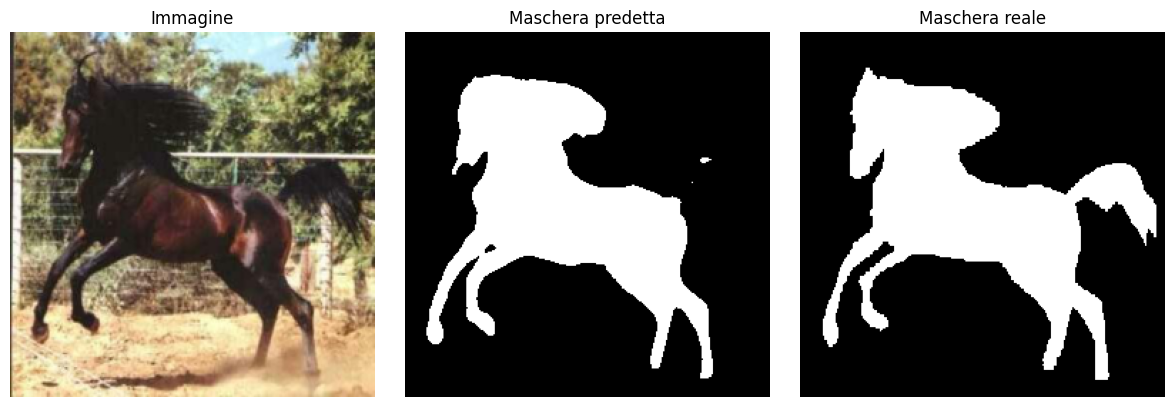

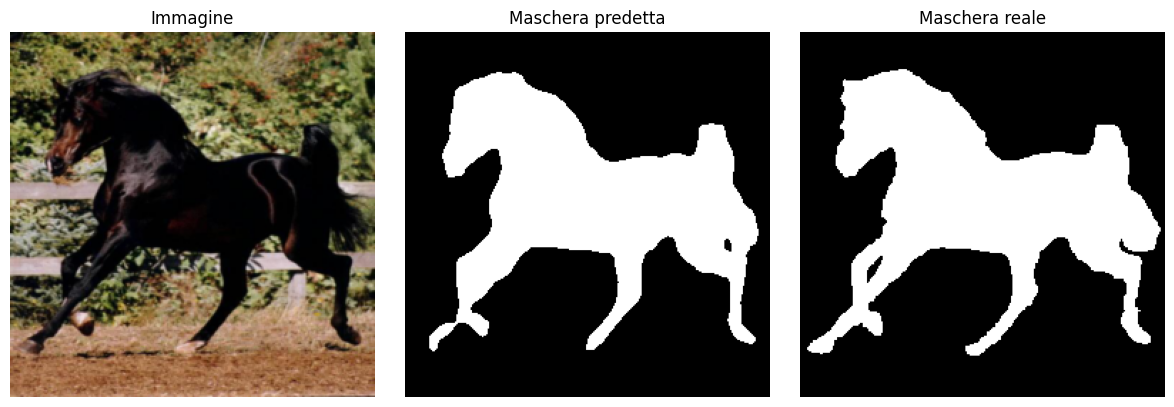

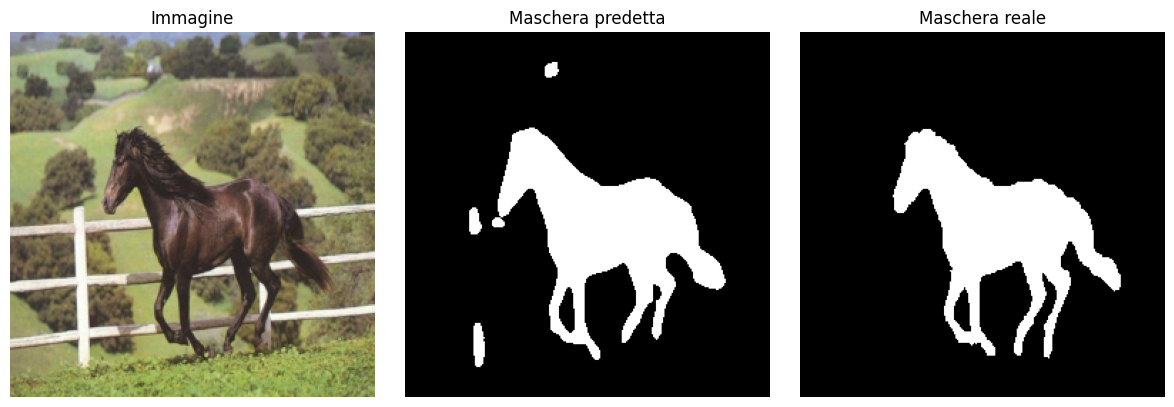

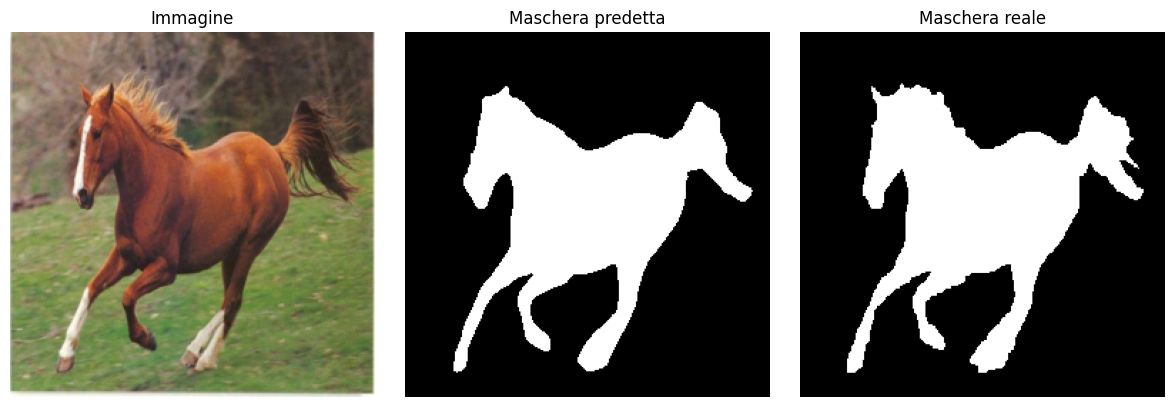

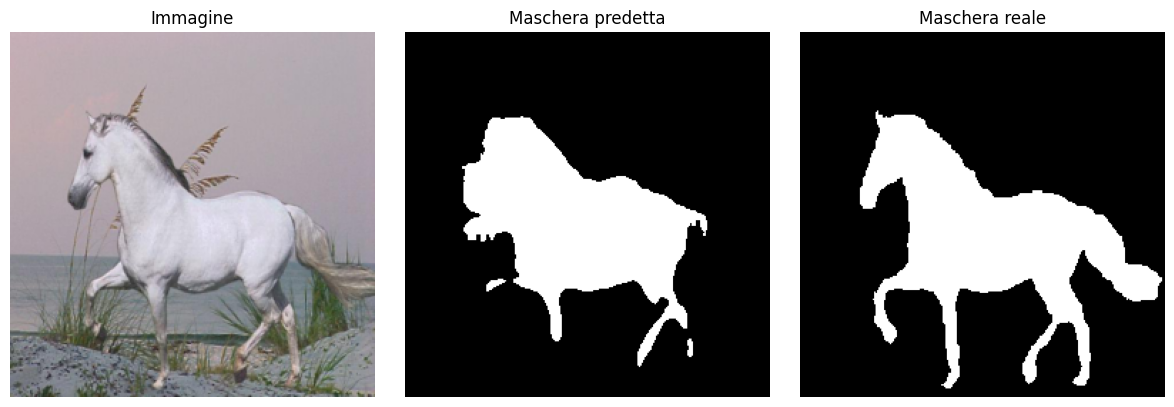

In [ ]:
for i in range(5):
  idx = np.random.randint(0, len(test_dataset))
  img, mask = test_dataset[idx]
  img = img.unsqueeze(0).to(device)
  mask = mask.unsqueeze(0).to(device)
  with torch.no_grad():
    pred = unet(img)
    plot_image_and_masks(img, torch.sigmoid(pred) > 0.5 , mask)

The final results suggest that the U-Net has learned to generalize reasonably well, producing accurate segmentation masks even on unseen data. While there is still room for improvement—particularly on finer boundaries—the current model provides a solid foundation for further experimentation or refinement.

However, some specific failure cases were observed: the model often gets confused in the presence of plants or vegetation, which are sometimes incorrectly recognized as horses. Additionally, when the horse is not monochrome, the model tends to segment moslty the fur of one color, ignoring the rest. These limitations highlight the need for more diverse training data or more advanced architectures to capture such nuances more effectively.